# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

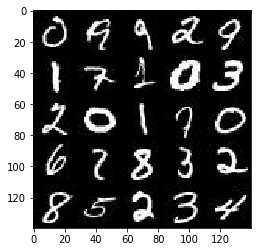

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

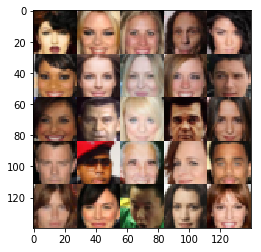

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_inputs = tf.placeholder(tf.float32, [None, image_width, image_height, image_channels], name='input_images')
    z_inputs = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, shape=(), name='learning_rate')
    
    return (real_inputs, z_inputs, learning_rate)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the generator, tensor logits of the generator).

In [6]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # The discriminator network is a regular convolutional network which takes in the real and fake images as input
    with tf.variable_scope('discriminator', reuse=reuse):
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        leaky_relu1 = tf.maximum(alpha*x1, x1)
        
        x2 = tf.layers.conv2d(leaky_relu1, 128, 5, strides=2, padding='SAME')
        batch_norm2 = tf.layers.batch_normalization(x2, training=True)
        leaky_relu2 = tf.maximum(alpha*batch_norm2, batch_norm2)

        x3 = tf.layers.conv2d(leaky_relu2, 256, 5, strides=1, padding='SAME')
        batch_norm3 = tf.layers.batch_normalization(x3, training=True)
        leaky_relu3 = tf.maximum(alpha*batch_norm3, batch_norm3)
        
        x4 = tf.layers.conv2d(leaky_relu3, 512, 5, strides=1, padding='SAME')
        batch_norm4 = tf.layers.batch_normalization(x4, training=True)
        leaky_relu4 = tf.maximum(alpha*batch_norm4, batch_norm4)

        # Now after the convolution layers we have to flatten the tensor and feed it into a fully-connected layer
        flattened_tensor = tf.reshape(leaky_relu4,(-1,7*7*512))
        logits = tf.layers.dense(flattened_tensor, 1)
        output = tf.sigmoid(logits) 
    return (output, logits)

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.25):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # The generator network works similar to a deconvolution network
    '''
    Reuse refers to when the variables of the generator will be used again. We want to first train the generator
    and then use it's trained variables to generate new images. So the is_train variable is used to monitor whether 
    the generator network is training or not, so that we can accordingly change reuse to the negative of training 
    mode to reuse variables when it is done training.
    '''
    with tf.variable_scope('generator', reuse= not is_train):
        ''' 
        For this network we will send the latent noise vector through a fully connected layer and then 
        reshape it into a deep convolutional stack layer
        '''
        x1 = tf.layers.dense(z, 7*7*512)
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.maximum(alpha*x1, x1)
        
        # Now for the transpose convolutions..
        x2 = tf.layers.conv2d_transpose(x1, 256, 3, strides=1, padding='SAME')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha*x2, x2)
    
        x3 = tf.layers.conv2d_transpose(x2, 128, 3, strides=1, padding='SAME')
        x3 = tf.layers.batch_normalization(x3, training=True)
        x3 = tf.maximum(alpha*x3, x3)

        x4 = tf.layers.conv2d_transpose(x3, 64, 3, strides=2, padding='SAME')
        x4 = tf.layers.batch_normalization(x4, training=True)
        x4 = tf.maximum(alpha*x4, x4)

        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 3, strides=2, padding='SAME')
        output = tf.tanh(logits)
        return output
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    generator_model = generator(input_z, out_channel_dim, is_train=True)
    disc_model_real, disc_logits_real = discriminator(input_real, reuse=False)
    disc_model_fake, disc_logits_fake = discriminator(generator_model, reuse=True)
    
    gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, 
                                        labels=tf.ones_like(disc_model_fake)))
    
    disc_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_real, 
                                        labels=tf.ones_like(disc_model_real)))
    
    disc_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_logits_fake, 
                                        labels=tf.zeros_like(disc_model_fake)))
    
    total_disc_loss = disc_loss_real + disc_loss_fake
    
    return (total_disc_loss, gen_loss)
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    trainable_vars = tf.trainable_variables()
    discriminator_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    generator_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    
    disc_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=discriminator_vars)
    gen_optimizer = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=generator_vars)
    
    return (disc_optimizer, gen_optimizer)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    disc_loss, gen_loss = model_loss(input_real, input_z, data_shape[3])
    disc_optimizer, gen_optimizer = model_opt(disc_loss, gen_loss, lr, beta1)
    batch_count = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images*2
                batch_count += 1
                # Random noise for each batch
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                # Running optimizers
                _ = sess.run(disc_optimizer, feed_dict={input_real: batch_images, input_z:batch_z, lr:learning_rate})
                _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, lr:learning_rate})
                _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, lr:learning_rate})
                _ = sess.run(gen_optimizer, feed_dict={input_z: batch_z, lr:learning_rate})
                
                # Evaluating the results
                if batch_count % 10 == 0:
                    train_loss_d = disc_loss.eval({input_real: batch_images, input_z:batch_z})
                    train_loss_g = gen_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if batch_count % 100 == 0:
                    show_generator_output(sess, 5, input_z, data_shape[3], data_image_mode)                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5... Discriminator Loss: 1.8900... Generator Loss: 1.8375
Epoch 1/5... Discriminator Loss: 4.2299... Generator Loss: 2.1255
Epoch 1/5... Discriminator Loss: 3.3595... Generator Loss: 1.1093
Epoch 1/5... Discriminator Loss: 2.7383... Generator Loss: 1.2726
Epoch 1/5... Discriminator Loss: 2.4279... Generator Loss: 1.1337
Epoch 1/5... Discriminator Loss: 1.5725... Generator Loss: 1.9927
Epoch 1/5... Discriminator Loss: 2.0713... Generator Loss: 1.5042
Epoch 1/5... Discriminator Loss: 1.6937... Generator Loss: 1.8715
Epoch 1/5... Discriminator Loss: 2.1566... Generator Loss: 2.3009
Epoch 1/5... Discriminator Loss: 1.4357... Generator Loss: 2.0482


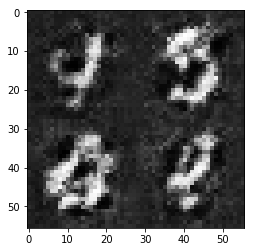

Epoch 1/5... Discriminator Loss: 2.9207... Generator Loss: 1.6579
Epoch 2/5... Discriminator Loss: 2.0293... Generator Loss: 0.1694
Epoch 2/5... Discriminator Loss: 1.9875... Generator Loss: 0.1889
Epoch 2/5... Discriminator Loss: 2.1481... Generator Loss: 0.1496
Epoch 2/5... Discriminator Loss: 2.0214... Generator Loss: 0.1791
Epoch 2/5... Discriminator Loss: 1.1218... Generator Loss: 1.1608
Epoch 2/5... Discriminator Loss: 1.3090... Generator Loss: 1.8536
Epoch 2/5... Discriminator Loss: 3.3752... Generator Loss: 2.1578
Epoch 2/5... Discriminator Loss: 1.2808... Generator Loss: 1.8069
Epoch 2/5... Discriminator Loss: 1.8410... Generator Loss: 2.0876


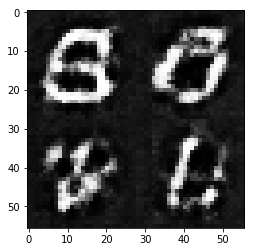

Epoch 2/5... Discriminator Loss: 1.0712... Generator Loss: 1.3391
Epoch 2/5... Discriminator Loss: 1.5860... Generator Loss: 2.0711
Epoch 2/5... Discriminator Loss: 1.3310... Generator Loss: 1.3896
Epoch 3/5... Discriminator Loss: 1.7437... Generator Loss: 1.6590
Epoch 3/5... Discriminator Loss: 1.5260... Generator Loss: 1.6867
Epoch 3/5... Discriminator Loss: 1.3322... Generator Loss: 1.4961
Epoch 3/5... Discriminator Loss: 1.5087... Generator Loss: 1.5422
Epoch 3/5... Discriminator Loss: 1.3962... Generator Loss: 1.5652
Epoch 3/5... Discriminator Loss: 1.8228... Generator Loss: 1.5020
Epoch 3/5... Discriminator Loss: 1.3101... Generator Loss: 0.8537


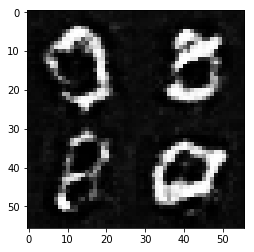

Epoch 3/5... Discriminator Loss: 1.2658... Generator Loss: 0.6776
Epoch 3/5... Discriminator Loss: 1.6093... Generator Loss: 1.0510
Epoch 3/5... Discriminator Loss: 1.4634... Generator Loss: 0.6739
Epoch 3/5... Discriminator Loss: 1.6831... Generator Loss: 1.4237
Epoch 3/5... Discriminator Loss: 1.4160... Generator Loss: 1.3003
Epoch 4/5... Discriminator Loss: 1.6987... Generator Loss: 1.4868
Epoch 4/5... Discriminator Loss: 1.2572... Generator Loss: 1.3998
Epoch 4/5... Discriminator Loss: 1.3783... Generator Loss: 0.9996
Epoch 4/5... Discriminator Loss: 1.8906... Generator Loss: 1.3258
Epoch 4/5... Discriminator Loss: 1.2901... Generator Loss: 0.9344


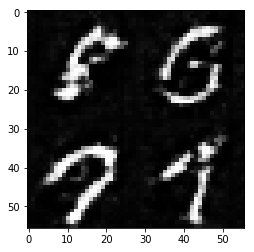

Epoch 4/5... Discriminator Loss: 1.9199... Generator Loss: 1.1837
Epoch 4/5... Discriminator Loss: 1.4862... Generator Loss: 0.4433
Epoch 4/5... Discriminator Loss: 2.5105... Generator Loss: 0.1056
Epoch 4/5... Discriminator Loss: 1.6180... Generator Loss: 0.3648
Epoch 4/5... Discriminator Loss: 1.7218... Generator Loss: 0.2828
Epoch 4/5... Discriminator Loss: 1.7207... Generator Loss: 0.3007
Epoch 5/5... Discriminator Loss: 2.0417... Generator Loss: 0.1931
Epoch 5/5... Discriminator Loss: 1.6367... Generator Loss: 0.3246
Epoch 5/5... Discriminator Loss: 1.5077... Generator Loss: 0.6219
Epoch 5/5... Discriminator Loss: 1.8050... Generator Loss: 1.4485


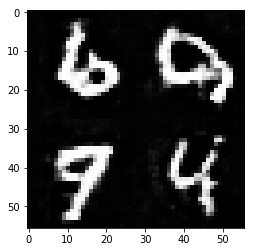

Epoch 5/5... Discriminator Loss: 1.4252... Generator Loss: 1.1930
Epoch 5/5... Discriminator Loss: 1.7089... Generator Loss: 0.2927
Epoch 5/5... Discriminator Loss: 1.6473... Generator Loss: 0.3205
Epoch 5/5... Discriminator Loss: 2.2215... Generator Loss: 0.1491
Epoch 5/5... Discriminator Loss: 1.4971... Generator Loss: 0.6987
Epoch 5/5... Discriminator Loss: 2.0830... Generator Loss: 0.1859
Epoch 5/5... Discriminator Loss: 1.5565... Generator Loss: 0.4147
Epoch 5/5... Discriminator Loss: 1.9863... Generator Loss: 0.2096


In [ ]:
batch_size = 512
z_dim = 128
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2... Discriminator Loss: 7.2811... Generator Loss: 0.0024
Epoch 1/2... Discriminator Loss: 5.4893... Generator Loss: 0.0070
Epoch 1/2... Discriminator Loss: 3.4824... Generator Loss: 0.0586
Epoch 1/2... Discriminator Loss: 2.5200... Generator Loss: 0.1975
Epoch 1/2... Discriminator Loss: 2.1085... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 2.0680... Generator Loss: 0.2435
Epoch 1/2... Discriminator Loss: 2.0327... Generator Loss: 0.3943
Epoch 1/2... Discriminator Loss: 1.9869... Generator Loss: 0.2988
Epoch 1/2... Discriminator Loss: 1.8506... Generator Loss: 0.3835
Epoch 1/2... Discriminator Loss: 2.1167... Generator Loss: 0.4414


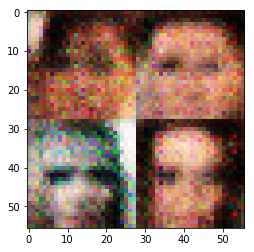

Epoch 1/2... Discriminator Loss: 1.7349... Generator Loss: 0.4093
Epoch 1/2... Discriminator Loss: 1.8995... Generator Loss: 0.4677
Epoch 1/2... Discriminator Loss: 2.1458... Generator Loss: 0.3831
Epoch 1/2... Discriminator Loss: 2.2813... Generator Loss: 0.3637
Epoch 1/2... Discriminator Loss: 1.9411... Generator Loss: 0.6220
Epoch 1/2... Discriminator Loss: 1.5663... Generator Loss: 0.4917
Epoch 1/2... Discriminator Loss: 1.7267... Generator Loss: 0.4760
Epoch 1/2... Discriminator Loss: 1.7287... Generator Loss: 0.5753
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 0.6136
Epoch 1/2... Discriminator Loss: 1.7434... Generator Loss: 0.5071


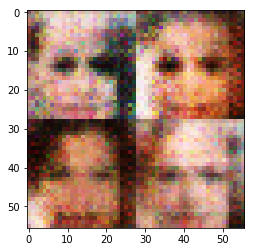

Epoch 1/2... Discriminator Loss: 1.6906... Generator Loss: 0.5712
Epoch 1/2... Discriminator Loss: 1.7106... Generator Loss: 0.5803
Epoch 1/2... Discriminator Loss: 1.6581... Generator Loss: 0.5585
Epoch 1/2... Discriminator Loss: 1.8494... Generator Loss: 0.5025
Epoch 1/2... Discriminator Loss: 1.7356... Generator Loss: 0.5457
Epoch 1/2... Discriminator Loss: 1.5905... Generator Loss: 0.5884
Epoch 1/2... Discriminator Loss: 1.5827... Generator Loss: 0.6019
Epoch 1/2... Discriminator Loss: 1.5608... Generator Loss: 0.6401
Epoch 1/2... Discriminator Loss: 1.5952... Generator Loss: 0.6293
Epoch 1/2... Discriminator Loss: 1.5684... Generator Loss: 0.6588


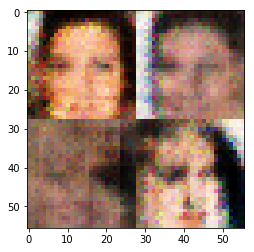

Epoch 1/2... Discriminator Loss: 1.6636... Generator Loss: 0.6149
Epoch 1/2... Discriminator Loss: 1.5878... Generator Loss: 0.6861
Epoch 1/2... Discriminator Loss: 1.6191... Generator Loss: 0.6404
Epoch 1/2... Discriminator Loss: 1.5270... Generator Loss: 0.6676
Epoch 1/2... Discriminator Loss: 1.5629... Generator Loss: 0.6254
Epoch 1/2... Discriminator Loss: 1.4961... Generator Loss: 0.6304
Epoch 1/2... Discriminator Loss: 1.5180... Generator Loss: 0.6077
Epoch 1/2... Discriminator Loss: 1.5586... Generator Loss: 0.7228
Epoch 1/2... Discriminator Loss: 1.5890... Generator Loss: 0.6631
Epoch 2/2... Discriminator Loss: 1.7205... Generator Loss: 0.5804


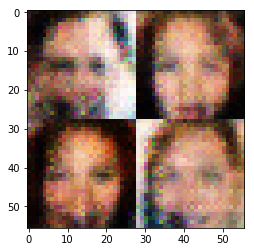

Epoch 2/2... Discriminator Loss: 1.5451... Generator Loss: 0.6184
Epoch 2/2... Discriminator Loss: 1.5288... Generator Loss: 0.6475
Epoch 2/2... Discriminator Loss: 1.5330... Generator Loss: 0.5861
Epoch 2/2... Discriminator Loss: 1.5040... Generator Loss: 0.5951
Epoch 2/2... Discriminator Loss: 1.5218... Generator Loss: 0.6538
Epoch 2/2... Discriminator Loss: 1.6727... Generator Loss: 0.5502
Epoch 2/2... Discriminator Loss: 1.5708... Generator Loss: 0.5669
Epoch 2/2... Discriminator Loss: 1.5318... Generator Loss: 0.6749
Epoch 2/2... Discriminator Loss: 1.5397... Generator Loss: 0.6446
Epoch 2/2... Discriminator Loss: 1.4675... Generator Loss: 0.7058


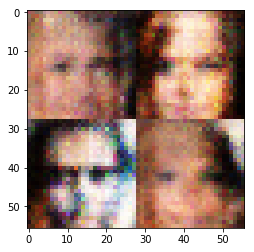

Epoch 2/2... Discriminator Loss: 1.5410... Generator Loss: 0.6901
Epoch 2/2... Discriminator Loss: 1.6338... Generator Loss: 0.5964
Epoch 2/2... Discriminator Loss: 1.5544... Generator Loss: 0.7098
Epoch 2/2... Discriminator Loss: 1.5345... Generator Loss: 0.6781
Epoch 2/2... Discriminator Loss: 1.5006... Generator Loss: 0.6004
Epoch 2/2... Discriminator Loss: 1.5290... Generator Loss: 0.6013
Epoch 2/2... Discriminator Loss: 1.5188... Generator Loss: 0.6918
Epoch 2/2... Discriminator Loss: 1.5038... Generator Loss: 0.6609
Epoch 2/2... Discriminator Loss: 1.5335... Generator Loss: 0.6493
Epoch 2/2... Discriminator Loss: 1.5670... Generator Loss: 0.6625


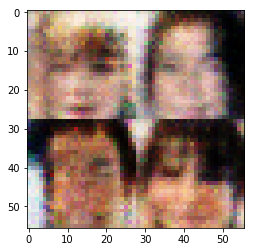

In [ ]:
batch_size = 512
z_dim = 784
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.